In [1]:
import os
os.environ['OMP_NUM_THREADS']='3'

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator

from dolfin import *

import sys
sys.path.insert(0, '../../')
from reaktoro_transport.problem.StokesFlowUzawa import StokesFlowUzawa

import reaktoro_transport.solver as solver
import reaktoro_transport.tools as tools

%matplotlib inline

In [2]:
# Reading mesh and MeshFunction that stores the fluid solid markers
mesh_xdmf = Mesh()

xdmf_obj = XDMFFile(MPI.comm_world, 'fluid_mesh.xdmf')
xdmf_obj.read(mesh_xdmf)

domain_markers = MeshFunction('size_t', mesh_xdmf, dim=2)
xdmf_obj.read(domain_markers)
xdmf_obj.close()

boundary_markers = MeshFunction('size_t', mesh_xdmf, dim=1)

xdmf_obj = XDMFFile(MPI.comm_world, 'fluid_boundary.xdmf')
xdmf_obj.read(boundary_markers)

xdmf_obj.close()

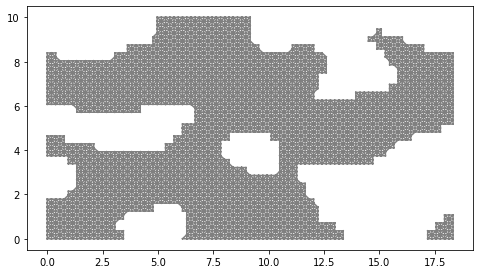

In [3]:
# Plot and show if mesh is properly read
plt.figure(figsize=(8,8))
plot(mesh_xdmf)
plt.show()

In [4]:
flow_problem = StokesFlowUzawa()

flow_problem.set_mesh(mesh_xdmf)
flow_problem.set_boundary_markers(boundary_markers)
flow_problem.set_domain_markers(domain_markers)

In [5]:
# Defining the inlet and noslip boundary markers
b_dict = {'inlet': [2, 3, 4], 'noslip': [10], 'velocity_bc': []}
flow_problem.mark_flow_boundary(**b_dict)

In [6]:
flow_problem.set_velocity_fe_space('CR', 1)
flow_problem.set_pressure_fe_space('DG', 0)

flow_problem.set_pressure_ic(Expression('0.0', degree=0))

p_dirichlet_list = [Constant(1.0), Constant(1.0), Constant(0.0)]
flow_problem.set_form_and_pressure_bc(p_dirichlet_list)
flow_problem.set_velocity_bc()

flow_problem.set_uzawa_parameters(r_val=1e3, omega_val=1e3)
flow_problem.assemble_matrix()
flow_problem.set_solver()

In [7]:
%%time
velocity, pressure = flow_problem.solve_flow(target_residual=1e-10, max_steps=10)

CPU times: user 2.44 s, sys: 1.5 s, total: 3.94 s
Wall time: 958 ms


In [8]:
# Check residual
flow_problem.get_residual()

7.742481119109064e-12

In [9]:
# Output to file
flow_problem.quick_save(file_name='pv_output_fluid_mesh')

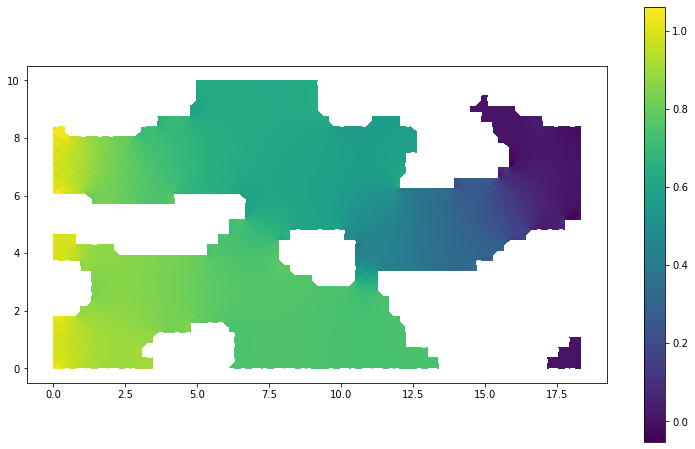

In [10]:
fig = plt.figure(figsize=(13,8))
cb = plot(pressure)
fig.colorbar(cb)
plt.show()